<a href="https://colab.research.google.com/github/bye23mj/suanLee/blob/main/DS_5_%ED%99%95%EB%A5%A0%EB%A1%A0%EC%A0%81_%EC%84%A0%ED%98%95_%ED%9A%8C%EA%B7%80%EB%AA%A8%ED%98%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.1 확률론적 선형 회귀모형
* OLS(Ordinary Least Square) 방법을 사용하면 데이터에 대한 확률론적인 가정이 없어도 최적의 가중치를 계산할 수 있었다. 그러나 계산한 가중치가 어느 정도의 신뢰도를 가지는지 확인할 수 있는 방법이 없다.

* 예를 들어 보스턴 집값의 선형 회귀모형에서 OLS로 계산한 범죄율에 대한 가중치는 약 −0.1080이었다. 만약 이 값이 정확한 값이라면 집값은 범죄율에 반비례한다는 결론을 내릴 수 있다. 하지만 −0.1080은 표본에서 계산된 추정치일 뿐이며 추정 오차가 있을 수 있다. 만약 추정 오차의 크기가 0.0001 수준이라면 실제 가중치는 −0.1080±0.0001 즉, −0.1081∼−0.1079 정도이고 집값이 범죄율에 반비례한다는 결론은 바뀌지 않을 것이다. 하지만 만약 추정 오차의 크기가 0.2 수준이라면 실제 가중치는 −0.3081∼0.0920 정도의 범위가 된다. 다시 말해 진짜 가중치는 0이 될 수도 있고 양수가 될 수 있다. 만약 가중치가 0이라면 범죄율과 집값은 아무런 상관 관계가 없다는 결론이 나온다. 만약 가중치가 양수이면 집값은 범죄율에 정비례한다는 결론이 나올 수도 있다. 

* 즉 가중치의 오차 범위 혹은 신뢰 구간을 계산할 수 없다면 OLS 결과로부터 실질적인 결론을 이끌어내기 어렵다.

## 부트스트래핑
* 부트스트래핑(bootstrapping)은 회귀분석에 사용한 표본 데이터가 달라질 때 회귀분석의 결과는 어느 정도 영향을 받는지를 알기 위한 방법이다.


In [24]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.datasets import make_regression

In [9]:
X0, y, coef = make_regression(n_samples=100, n_features=1, noise=20,
                              coef=True, random_state=0)
coef

array(42.38550486)

In [10]:
dfX0 = pd.DataFrame(X0, columns=["X1"])
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(y, columns=["y"])

model = sm.OLS(dfy, dfX)
result = model.fit()

In [11]:
result.params

const    -1.628364
X1       42.853356
dtype: float64

In [14]:
%%time
N = 1000
params_w0 = np.zeros(N)
params_w1 = np.zeros(N)
for i in range(N):
    idx = np.random.choice(len(dfy), len(dfy), replace=True)
    dfX2 = dfX.iloc[idx, :]
    dfy2 = dfy.iloc[idx]
    r = sm.OLS(dfy2, dfX2).fit()
    params_w0[i] = r.params.const
    params_w1[i] = r.params.X1

CPU times: user 1.26 s, sys: 0 ns, total: 1.26 s
Wall time: 1.26 s


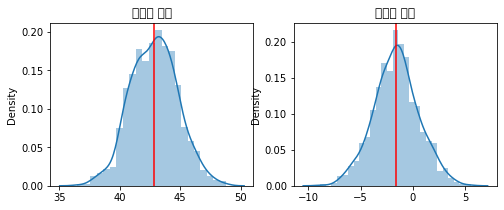

In [19]:
plt.figure(figsize=(8, 3))

ax1 = plt.subplot(121)
sns.distplot(params_w1, ax=ax1)
plt.axvline(params_w1.mean(), c='r')
plt.title("추정치 분포")

ax2 = plt.subplot(122)
sns.distplot(params_w0, ax=ax2)
plt.axvline(params_w0.mean(), c='r')
plt.title("추정치 분포")
plt.show()

In [20]:
params_w1.mean(), params_w1.std()

(42.84434285514176, 1.9434315375339744)

In [21]:
params_w0.mean(), params_w0.std()

(-1.5998477716889103, 2.152618501374801)

In [22]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     400.3
Date:                Tue, 31 May 2022   Prob (F-statistic):           2.21e-36
Time:                        05:57:27   Log-Likelihood:                -448.09
No. Observations:                 100   AIC:                             900.2
Df Residuals:                      98   BIC:                             905.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6284      2.163     -0.753      0.4

## 확률론적 선형 회귀모형
확률론적 선형 회귀모형에서는 데이터가 확률 변수로부터 생성된 표본이라고 가정한다. 구체적인 가정은 다음과 같다.

### (1) 선형 정규 분포 가정
* 선형 회귀분석의 기본 가정은 종속 변수 y가 독립 변수 x의 선형 조합으로 결정되는 기댓값과 고정된 분산을 가지는 가우시안 정규 분포

### (2) 외생성(Exogeneity) 가정
* 잡음 ϵ의 기댓값은 독립 변수 x의 크기에 상관없이 항상 0이라고 가정한다.

### (3) 조건부 독립 가정
* i번째 표본의 잡음 ϵi와 j번째 표본의 잡음 ϵj의 공분산 값이 x와 상관없이 항상 0이라고 가정한다.

### 4) 등분산성 가정
* i 번째 표본의 잡음 ϵi와 j번째 표본의 잡음 ϵj의 분산 값이 표본과 상관없이 항상 같다고 가정한다.



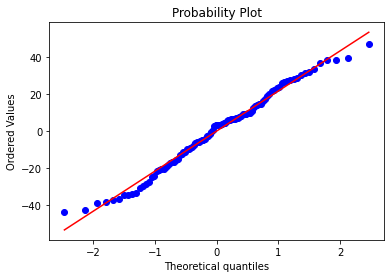

In [25]:
#잔차분포
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [26]:
#정규성 검정
test = sm.stats.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  3.523
P-value     :  0.172


In [27]:
test = sm.stats.jarque_bera(result.resid)
for xi in zip(['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis'], test):
    print("%-12s: %6.3f" % xi)

Jarque-Bera :  2.059
P-value     :  0.357
Skew        : -0.073
Kurtosis    :  2.312


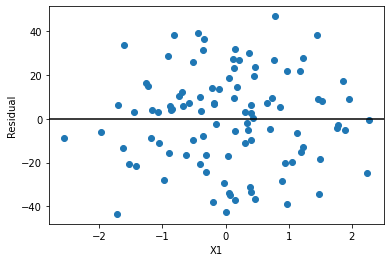

In [28]:
plt.plot(X0, result.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("X1")
plt.ylabel("Residual")
plt.show()

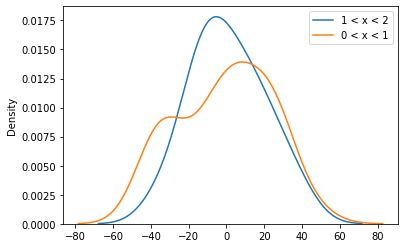

In [29]:
sns.kdeplot(result.resid[((1 < X0) & (X0 < 2)).flatten()], label="1 < x < 2")
sns.kdeplot(result.resid[((0 < X0) & (X0 < 1)).flatten()], label="0 < x < 1")
plt.legend()
plt.show()

## 회귀 계수의 표준 오차¶
* 가중치의 예측치 w^ 도 정규 분포 확률 변수인 ϵ의 선형 변환이므로 정규 분포를 따른다.

## 단일 계수 t-검정 (Single Coefficient t-test)¶
정규화된 모수 오차 w^isei를 검정 통계량으로 사용하면 wi가 0 인지 아닌지에 대한 검정을 실시할 수 있다.

In [30]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     400.3
Date:                Tue, 31 May 2022   Prob (F-statistic):           2.21e-36
Time:                        06:29:51   Log-Likelihood:                -448.09
No. Observations:                 100   AIC:                             900.2
Df Residuals:                      98   BIC:                             905.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6284      2.163     -0.753      0.4

In [31]:
#x1에 대한 계수값 w1을 40으로 해도 되는지 테스트할 수도 있다.
print(result.t_test("X1 = 40"))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            42.8534      2.142      1.332      0.186      38.603      47.104


In [32]:
#월평균 기온을 나타내는 nottem 데이터에서 1월과 2월의 기온이 실질적으로 같은지를 알아볼 때도 사용

import datetime
from calendar import isleap

df_nottem = sm.datasets.get_rdataset("nottem").data 

def convert_partial_year(number):
    year = int(number)
    d = datetime.timedelta(days=(number - year) * (365 + isleap(year)))
    day_one = datetime.datetime(year, 1, 1)
    date = d + day_one
    return date

df_nottem["date0"] = df_nottem[["time"]].applymap(convert_partial_year)
df_nottem["date"] = pd.DatetimeIndex(df_nottem["date0"]).round('60min') + datetime.timedelta(seconds=3600*24)
df_nottem["month"] = df_nottem["date"].dt.strftime("%m").astype('category')
del df_nottem["date0"], df_nottem["date"]

model_nottem = sm.OLS.from_formula("value ~ C(month) + 0", df_nottem)
result_nottem = model_nottem.fit()
print(result_nottem.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     277.3
Date:                Tue, 31 May 2022   Prob (F-statistic):          2.96e-125
Time:                        06:31:48   Log-Likelihood:                -535.82
No. Observations:                 240   AIC:                             1096.
Df Residuals:                     228   BIC:                             1137.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
C(month)[01]    39.6950      0.518     76.691   

In [33]:
#0.25이상으로 유의하지 않다
print(result_nottem.t_test("C(month)[01] = C(month)[02]"))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.5050      0.732      0.690      0.491      -0.937       1.947


In [34]:
#0.25이하로 유의하다
print(result_nottem.t_test("C(month)[03] = C(month)[02]"))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             3.0050      0.732      4.105      0.000       1.563       4.447


# 5.2 회귀분석의 기하학

# 5.3 레버리지와 아웃라이어
## 레버리지
* 개별적인 데이터 표본 하나하나가 회귀분석 결과에 미치는 영향력은 레버리지 분석이나 아웃라이어 분석을 통해 알 수 있다.

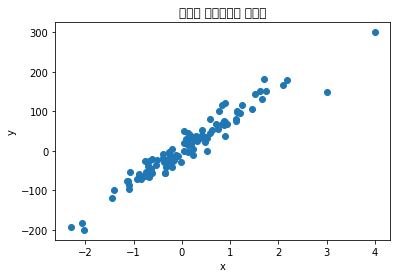

In [35]:
from sklearn.datasets import make_regression

# 100개의 데이터 생성
X0, y, coef = make_regression(n_samples=100, n_features=1, noise=20,
                              coef=True, random_state=1)

# 레버리지가 높은 가상의 데이터를 추가
data_100 = (4, 300)
data_101 = (3, 150)
X0 = np.vstack([X0, np.array([data_100[:1], data_101[:1]])])
X = sm.add_constant(X0)
y = np.hstack([y, [data_100[1], data_101[1]]])

plt.scatter(X0, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("가상의 회귀분석용 데이터")
plt.show()

In [36]:
model = sm.OLS(pd.DataFrame(y), pd.DataFrame(X))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     1464.
Date:                Tue, 31 May 2022   Prob (F-statistic):           1.61e-61
Time:                        06:42:09   Log-Likelihood:                -452.71
No. Observations:                 102   AIC:                             909.4
Df Residuals:                     100   BIC:                             914.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              3.2565      2.065      1.577      0.1

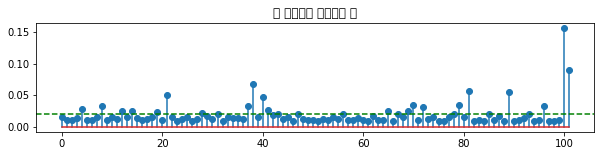

In [40]:
#get_influence 메서드를 호출하여 영향도 정보 확인
influence = result.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(10, 2))
plt.stem(hat)
plt.axhline(0.02, c="g", ls="--")
plt.title("각 데이터의 레버리지 값")
plt.show()

In [38]:
hat.sum()

2.0000000000000004

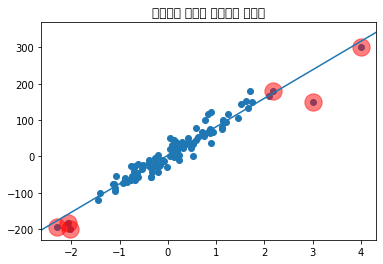

In [41]:
#레버리지가 큰 데이터만 표시
ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result, ax=ax)

idx = hat > 0.05
plt.scatter(X0[idx], y[idx], s=300, c="r", alpha=0.5)
plt.title("회귀분석 결과와 레버리지 포인트")
plt.show()

### 레버리지의 영향

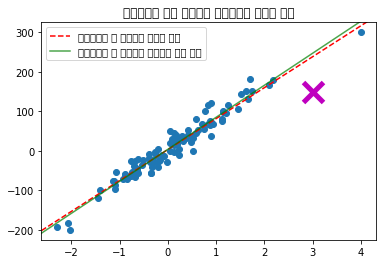

In [51]:
#레버리지가 큰 데이터는 포함되거나 포함되지 않는가에 따라 모형에 주는 영향이 큼
model2 = sm.OLS(y[:-1], X[:-1])
result2 = model2.fit()

ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result, c="r", linestyle="--", ax=ax)
sm.graphics.abline_plot(model_results=result2, c="g", alpha=0.7, ax=ax)

plt.plot(X0[-1], y[-1], marker='x', c="m", ms=20, mew=5)
plt.legend([u"레버리지가 큰 데이터를 포함한 경우", u"레버리지가 큰 데이터를 포함하지 않은 경우"], loc="upper left")
plt.title("레버리지가 높은 데이터가 회귀분석에 미치는 영향")
plt.show()

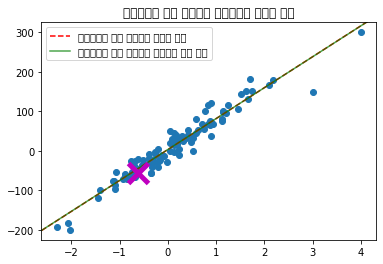

In [48]:
model3 = sm.OLS(y[1:], X[1:])
result3 = model3.fit()

ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result, c="r", linestyle="--", ax=ax)
sm.graphics.abline_plot(model_results=result3, c="g", alpha=0.7, ax=ax)

plt.plot(X0[0], y[0], marker='x', c="m", ms=20, mew=5)
plt.legend([u"레버리지가 작은 데이터를 포함한 경우", u"레버리지가 작은 데이터를 포함하지 않은 경우"],
           loc="upper left")
plt.title("레버리지가 작은 데이터가 회귀분석에 미치는 영향")
plt.show()

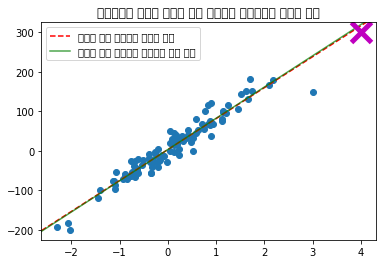

In [49]:
#레버리지가 크더라도 오차가 작은 데이터는 포함되거나 포함되지 않거나 모형이 별로 달라지지 않음
idx = np.array(list(range(100)) + [101])
model4 = sm.OLS(y[idx], X[idx, :])
result4 = model4.fit()

ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result,
                        c="r", linestyle="--", ax=ax)
sm.graphics.abline_plot(model_results=result4,
                        c="g", alpha=0.7, ax=ax)

plt.plot(X0[-2], y[-2], marker='x', c="m", ms=20, mew=5)
plt.legend([u"오차가 작은 데이터를 포함한 경우", u"오차가 작은 데이터를 포함하지 않은 경우"],
           loc="upper left")
plt.title("레버리지는 높지만 오차가 작은 데이터가 회귀분석에 미치는 영향")
plt.show()

## 아웃라이어
* 모형에서 설명하고 있는 데이터와 동떨어진 값을 가지는 데이터, 즉 잔차가 큰 데이터를 **아웃라이어(outlier)**라고 한다. 그런데 잔차의 크기는 독립 변수의 영향을 받으므로 아웃라이어를 찾으러면 이 영향을 제거한 표준화된 잔차를 계산해야 한다.

### statsmodels를 이용한 표준화 잔차 계산

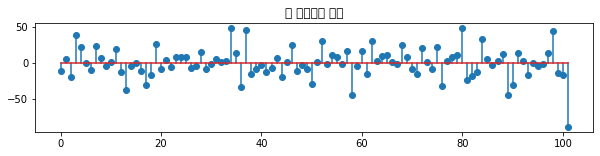

In [52]:
plt.figure(figsize=(10, 2))
plt.stem(result.resid)
plt.title("각 데이터의 잔차")
plt.show()

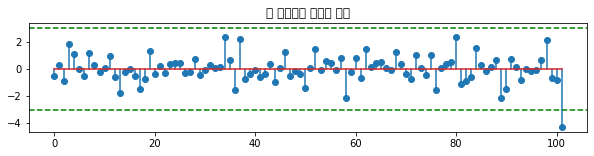

In [53]:
plt.figure(figsize=(10, 2))
plt.stem(result.resid_pearson)
plt.axhline(3, c="g", ls="--")
plt.axhline(-3, c="g", ls="--")
plt.title("각 데이터의 표준화 잔차")
plt.show()

### Cook’s Distance
* 회귀 분석에는 잔차의 크기가 큰 데이터가 아웃라이어가 되는데 이 중에서도 주로 관심을 가지는 것은 레버리지와 잔차의 크기가 모두 큰 데이터들이다. 잔차와 레버리지를 동시에 보기위한 기준으로는 Cook’s Distance가 있다. 다음과 같이 정의되는 값으로 레버리지가 커지거나 잔차의 크기가 커지면 Cook’s Distance 값이 커진다.

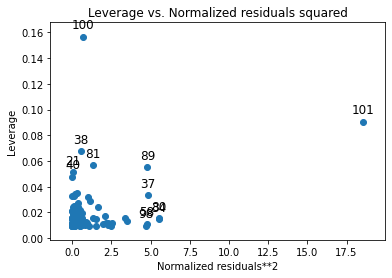

In [54]:
#모든 데이터의 레버리지와 잔차를 동시에 보려면 plot_leverage_resid2 명령을 사용
sm.graphics.plot_leverage_resid2(result)
plt.show()

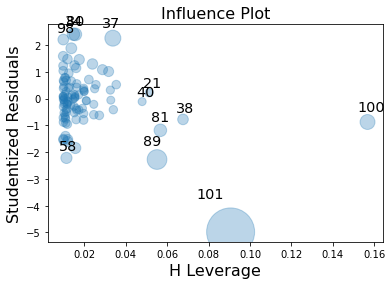

In [55]:
# influence_plot 명령을 사용하면 Cook’s distance를 버블 크기로 표시
sm.graphics.influence_plot(result, plot_alpha=0.3)
plt.show()

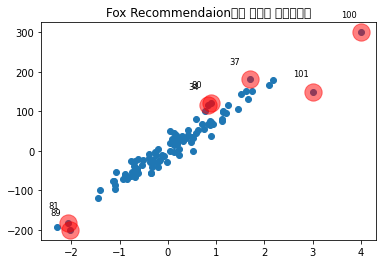

In [56]:
#Fox recommentation 기준으로 아웃라이어를 선택

from statsmodels.graphics import utils
cooks_d2, pvals = influence.cooks_distance
K = influence.k_vars
fox_cr = 4 / (len(y) - K - 1)
idx = np.where(cooks_d2 > fox_cr)[0]

ax = plt.subplot()
plt.scatter(X0, y)
plt.scatter(X0[idx], y[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx, list(zip(X0[idx], y[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.title("Fox Recommendaion으로 선택한 아웃라이어")
plt.show()

# 보스턴 집값 예측 문제

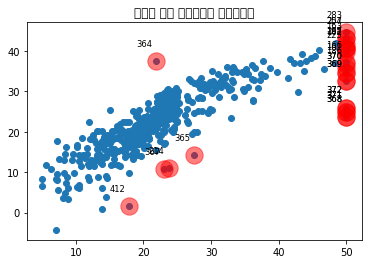

In [57]:
from sklearn.datasets import load_boston
boston = load_boston()

dfX0 = pd.DataFrame(boston.data, columns=boston.feature_names)
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])

model_boston = sm.OLS(dfy, dfX)
result_boston = model_boston.fit()
pred = result_boston.predict(dfX)

influence_boston = result_boston.get_influence()
cooks_d2, pvals = influence_boston.cooks_distance
K = influence.k_vars
fox_cr = 4 / (len(y) - K - 1)
idx = np.where(cooks_d2 > fox_cr)[0]

# MEDV = 50 제거
idx = np.hstack([idx, np.where(boston.target == 50)[0]])

ax = plt.subplot()
plt.scatter(dfy, pred)
plt.scatter(dfy.MEDV[idx], pred[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx,
                    list(zip(dfy.MEDV[idx], pred[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.title("보스턴 집값 데이터에서 아웃라이어")
plt.show()

In [58]:
idx2 = list(set(range(len(dfX))).difference(idx))
dfX = dfX.iloc[idx2, :].reset_index(drop=True)
dfy = dfy.iloc[idx2, :].reset_index(drop=True)
model_boston2 = sm.OLS(dfy, dfX)
result_boston2 = model_boston2.fit()
print(result_boston2.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     156.1
Date:                Tue, 31 May 2022   Prob (F-statistic):          2.41e-161
Time:                        07:00:46   Log-Likelihood:                -1285.2
No. Observations:                 485   AIC:                             2598.
Df Residuals:                     471   BIC:                             2657.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.8999      4.107      4.602      0.0

# 5.4 분산 분석과 모형 성능

## 분산 분석
* 선형회귀분석의 결과가 얼마나 좋은지는 단순히 잔차제곱합(RSS: Residula Sum of Square)으로 평가할 수 없다. 변수의 단위 즉, 스케일이 달라지면 회귀분석과 상관없이 잔차제곱합도 달라지기 때문이다.

* 분산 분석(ANOVA: Analysis of Variance)은 종속변수의 분산과 독립변수의 분산간의 관계를 사용하여 선형회귀분석의 성능을 평가하고자 하는 방법이다. 분산 분석은 서로 다른 두 개의 선형회귀분석의 성능 비교에 응용할 수 있으며 독립변수가 카테고리 변수인 경우 각 카테고리 값에 따른 영향을 정량적으로 분석하는데도 사용된다.

* TSS(total sum of square) : 종속변수값의 움직임의 범위
* ESS(explained sum of squares) : 모형에서 나온 예측값의 움직임의 범위
* RSS(residual sum of squares) : 잔차의 움직임의 범위, 즉 오차의 크기

* TSS=ESS+RSS

* 모형 예측치의 움직임의 크기(분산)은 종속변수의 움직임의 크기(분산)보다 클 수 없다.
* 모형의 성능이 좋을수록 모형 예측치의 움직임의 크기는 종속변수의 움직임의 크기와 비슷해진다.

In [59]:
from sklearn.datasets import make_regression

X0, y, coef = make_regression(n_samples=100, n_features=1, noise=30, coef=True, random_state=0)
dfX0 = pd.DataFrame(X0, columns=["X"])
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(y, columns=["Y"])
df = pd.concat([dfX, dfy], axis=1)

model = sm.OLS.from_formula("Y ~ X", data=df)
result = model.fit()

In [60]:
print("TSS = ", result.uncentered_tss)
print("ESS = ", result.mse_model)
print("RSS = ", result.ssr)
print("ESS + RSS = ", result.mse_model + result.ssr)
print("R squared = ", result.rsquared)

TSS =  291345.7578983061
ESS =  188589.61349210917
RSS =  102754.33755137534
ESS + RSS =  291343.9510434845
R squared =  0.6473091780922585


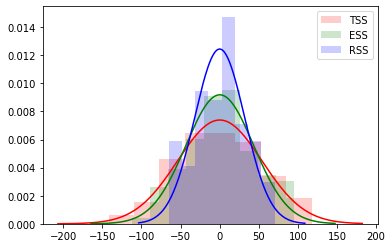

In [61]:
sns.distplot(y,
             kde=False, fit=sp.stats.norm, hist_kws={"color": "r", "alpha": 0.2}, fit_kws={"color": "r"},
             label="TSS")
sns.distplot(result.fittedvalues,
             kde=False, hist_kws={"color": "g", "alpha": 0.2}, fit=sp.stats.norm, fit_kws={"color": "g"},
             label="ESS")
sns.distplot(result.resid,
             kde=False, hist_kws={"color": "b", "alpha": 0.2}, fit=sp.stats.norm, fit_kws={"color": "b"},
             label="RSS")
plt.legend()
plt.show()

## 결정계수(Coefficient of Determination)

* 분산 관계식에서 모형의 성능을 나타내는 결정계수(Coefficient of Determination) 
* R squared를 정의
  * R2≡1−RSS/TSS = ESS/TSS 
  * 0≤R2≤1


## 회귀 분석 F-검정과 분산 분석의 관계

In [62]:
sm.stats.anova_lm(result)

,df,sum_sq,mean_sq,F,PR(>F)
X,1.0,188589.613492,188589.613492,179.863766,6.601482e-24
Residual,98.0,102754.337551,1048.513648,NaN,NaN


In [63]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     179.9
Date:                Tue, 31 May 2022   Prob (F-statistic):           6.60e-24
Time:                        07:31:37   Log-Likelihood:                -488.64
No. Observations:                 100   AIC:                             981.3
Df Residuals:                      98   BIC:                             986.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4425      3.244     -0.753      0.4

## 결정 계수와 상관 계수

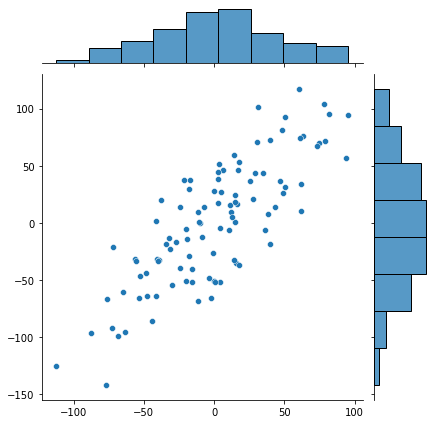

In [64]:
sns.jointplot(result.fittedvalues, y)
plt.show()

## 상수항이 없는 모형의 경우
* 모형의 결정계수를 비교할 때 상수항이 없는 모형과 상수항이 있는 모형은 직접 비교하면 안된다.

In [65]:
X0, y, coef = make_regression(
    n_samples=100, n_features=1, noise=30, bias=100, coef=True, random_state=0)
dfX = pd.DataFrame(X0, columns=["X"])
dfy = pd.DataFrame(y, columns=["Y"])
df = pd.concat([dfX, dfy], axis=1)

model2 = sm.OLS.from_formula("Y ~ X + 0", data=df)
result2 = model2.fit()

result2.rsquared

0.1876872470594393

## F 검정을 이용한 모형 비교
* F 검정을 이용하면 다음과 같이 포함관계(nesting)에 있는 두 모형의 성능을 비교할 수 있다.
  * 전체 모형(Full Model): $y=w0+w1x1+w2x2+w3x3$
  * 축소 모형(Reduced Model): $y=w0+w1x1$

In [69]:
from sklearn.datasets import load_boston

boston = load_boston()
dfX0_boston = pd.DataFrame(boston.data, columns=boston.feature_names)
dfy_boston = pd.DataFrame(boston.target, columns=["MEDV"])
dfX_boston = sm.add_constant(dfX0_boston)
df_boston = pd.concat([dfX_boston, dfy_boston], axis=1)

In [70]:
model_full = sm.OLS.from_formula(
    "MEDV ~ CRIM + ZN + INDUS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT + CHAS", data=df_boston)
model_reduced = sm.OLS.from_formula(
    "MEDV ~ CRIM + ZN + NOX + RM + DIS + RAD + TAX + PTRATIO + B + LSTAT + CHAS", data=df_boston)

sm.stats.anova_lm(model_reduced.fit(), model_full.fit())

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,494.0,11081.363952,0.0,NaN,NaN,NaN
1,492.0,11078.784578,2.0,2.579374,0.057274,0.944342


## F 검정을 사용한 변수 중요도 비교
* F 검정은 각 독립변수의 중요도를 비교하기 위해 사용할 수 있다. 방법은 전체 모형과 각 변수 하나만을 뺀 모형들의 성능을 비교

In [71]:
model_full = sm.OLS.from_formula(
    "MEDV ~ CRIM + ZN + INDUS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT + CHAS", data=df_boston)
model_reduced = sm.OLS.from_formula(
    "MEDV ~ ZN + INDUS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT + CHAS", data=df_boston)

sm.stats.anova_lm(model_reduced.fit(), model_full.fit())

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,493.0,11322.004277,0.0,NaN,NaN,NaN
1,492.0,11078.784578,1.0,243.219699,10.801193,0.001087


In [72]:
# anova_lm 명령에서는 typ 인수를 2로 지정하면 하나 하나의 변수를 뺀 축소 모형에서의 F 검정값을 한꺼번에 계산
model_boston = sm.OLS.from_formula(
    "MEDV ~ CRIM + ZN + INDUS + NOX + RM + AGE + DIS + RAD + TAX + PTRATIO + B + LSTAT + CHAS", data=df_boston)
result_boston = model_boston.fit()
sm.stats.anova_lm(result_boston, typ=2)

,sum_sq,df,F,PR(>F)
CRIM,243.219699,1.0,10.801193,1.086810e-03
ZN,257.492979,1.0,11.435058,7.781097e-04
INDUS,2.516668,1.0,0.111763,7.382881e-01
NOX,487.155674,1.0,21.634196,4.245644e-06
RM,1871.324082,1.0,83.104012,1.979441e-18
AGE,0.061834,1.0,0.002746,9.582293e-01
DIS,1232.412493,1.0,54.730457,6.013491e-13
RAD,479.153926,1.0,21.278844,5.070529e-06
TAX,242.257440,1.0,10.758460,1.111637e-03
PTRATIO,1194.233533,1.0,53.034960,1.308835e-12
